# XBeach data demo

In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
from pathlib import Path
import numpy as np
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

from rompy_xbeach.grid import Ori, RegularGrid

import warnings
warnings.filterwarnings("ignore")

## Read bathy

Read bathy from the test data to inspect and help defining the model grid

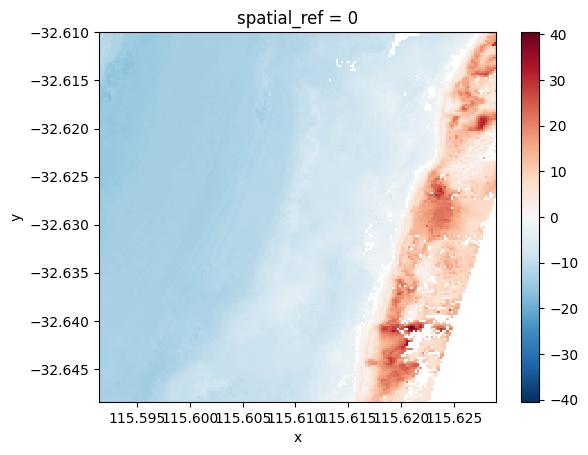

In [3]:
bathy = rioxarray.open_rasterio("../../../rompy-xbeach/tests/data/bathy.tif")
bathy = bathy.isel(band=0, drop=True)
bathy.plot()

## Set the grid

Define the XBeach grid object in `EPSG:28350` projection (use latlon to specify the origin)

In [9]:
grid = RegularGrid(
    ori=Ori(
        x=115.594239,
        y=-32.641104,
        crs="epsg:4326",
    ),
    alfa=347,
    dx=10,
    dy=15,
    nx=230,
    ny=220,
    crs="28350",
)

### Plot grid on bathy

The origin and rotation of the grid needs to be defined such that the offshore boundary
of the interpolated bathymetry data corresponds to the first row and column. The `grid.plot()`
method highlights the origin and offshore boundary in red to assist with the grid definition

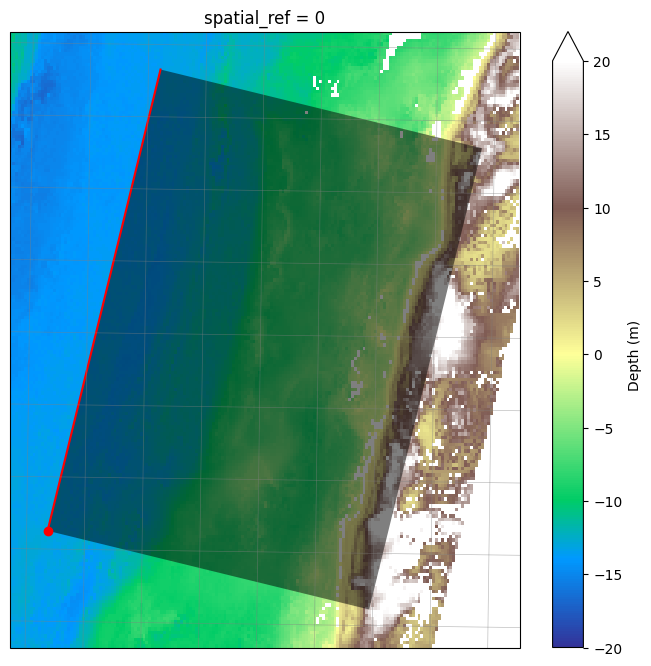

In [7]:
projection = ccrs.Stereographic(
    central_longitude=grid.ori.x, central_latitude=grid.ori.y
)
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(8.5, 8))

# Bathymetry
bathy.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="terrain",
    vmin=-20,
    vmax=20,
    cbar_kwargs=dict(label="Depth (m)"),
)

# Grid
ax = grid.plot(
    ax=ax,
    buffer=250,
    grid_kwargs=dict(facecolor="k", alpha=0.5, zorder=2),
    show_offshore=True,
    show_origin=True,
)

<div class="alert alert-block alert-warning">
⚠️ Here we will define another grid by poorly selecting the origin and rotation
</div>

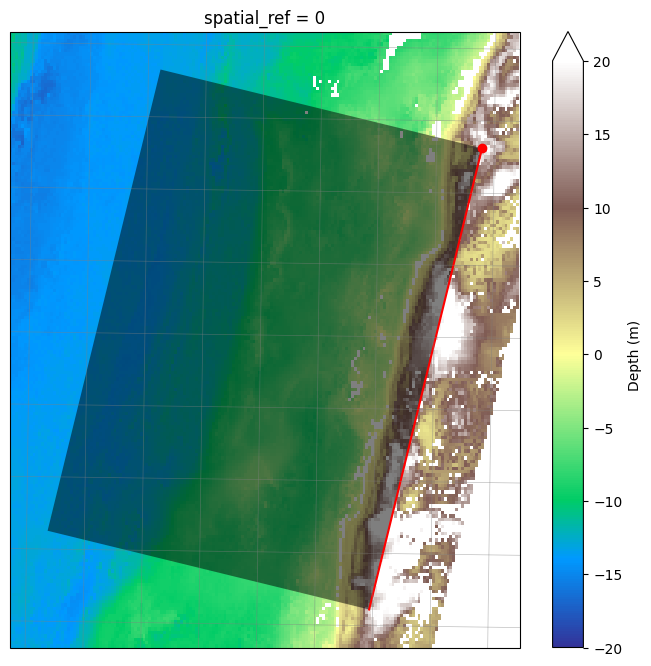

In [8]:
# Define origin at the NE corner of the existing grid
x0 = grid.x[-1, -1]
y0 = grid.y[-1, -1]

# Notice we are now specifying the origin in projected coordinates!
grid_bad = RegularGrid(
    ori=Ori(x=x0, y=y0, crs=28350),
    alfa=347-180,
    dx=10,
    dy=15,
    nx=230,
    ny=220,
    crs="28350",
)

# Plotting
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(8.5, 8))
bathy.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="terrain",
    vmin=-20,
    vmax=20,
    cbar_kwargs=dict(label="Depth (m)"),
)
ax = grid_bad.plot(ax=ax, buffer=250, grid_kwargs=dict(facecolor="k", alpha=0.5, zorder=2))

## Set Data object

Define the data with a `SourceGeotiff` source and use the grid created above to create the model files

In [10]:
from rompy_xbeach.source import SourceGeotiff
from rompy_xbeach.data import XBeachBathy, SeawardExtensionLinear
from rompy_xbeach.interpolate import RegularGridInterpolator

### Example 1: no extension of the grid

We start off by defining source and interpolator instances

In [146]:
# The source instance provides the source dataset with the CRS information
source = SourceGeotiff(filename="../../../rompy-xbeach/tests/data/bathy.tif")

# The interpolator instance specify how the interpolation will be done
interpolator = RegularGridInterpolator(
    kwargs=dict(
        method="linear",
        fill_value=None,
    ),
)

Then we instantiate the bathy data object

In [26]:
data = XBeachBathy(
    source=source,
    posdwn=False,
    interpolator=interpolator,
)

Lastly, we use the previously defined grid instance to interpolate the bathy onto

In [13]:
workspace = Path("./example1")
workspace.mkdir(exist_ok=True)

xfile1, yfile1, datafile1, grid1 = data.get(destdir=workspace, grid=grid)
sorted(workspace.glob("*.txt"))

INFO:rompy_xbeach.data:Reprojecting ../../../rompy-xbeach/tests/data/bathy.tif to EPSG:28350


[PosixPath('example1/data.txt'),
 PosixPath('example1/xdata.txt'),
 PosixPath('example1/ydata.txt')]

Let's plot the grid and generated bathy to visualise

In [135]:
def plot_model_bathy(xfile, yfile, datafile, grid):
    """Plot the model bathy"""

    # Read the generated files
    x = np.loadtxt(xfile)
    y = np.loadtxt(yfile)
    data = np.loadtxt(datafile)

    # Set the figure
    fig = plt.figure(figsize=(15, 12))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1.5, 1], width_ratios=[1, 1])

    # =========================
    # Plot in real coordinates
    # =========================
    ax = plt.subplot(gs[0], projection=grid.projection)
    ax.pcolormesh(x, y, data, transform=grid.transform, vmin=-20, vmax=20, cmap="terrain")
    ax = grid.plot(
        ax=ax,
        buffer=50,
        grid_kwargs=dict(edgecolor="k", facecolor="none"),
        show_mesh=True,
        mesh_step=5,
        mesh_kwargs=dict(color="k", linewidth=0.3, alpha=0.5),
    )
    ax.set_title("Real coordinates")

    # ==========================
    # Plot in model coordinates
    # ==========================
    ax = plt.subplot(gs[1])
    x = np.arange(grid.nx) * grid.dx
    y = np.arange(grid.ny) * grid.dy
    p = ax.pcolormesh(x, y, data, vmin=-20, vmax=20, cmap="terrain")
    plt.colorbar(p)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    xlim = 0, x[-1]
    ax.set_xlim(xlim)
    ax.set_aspect("equal", "box")
    ax.set_title("Model coordinates")

    # =============================
    # Plot the cross-shore profile
    # =============================
    ax = plt.subplot(gs[1, :])
    x = np.arange(grid.nx) * grid.dx
    slopes = np.zeros((grid.ny, grid.nx))
    for iy in range(grid.ny):
        ax.plot(x, data[iy, :], color="0.5", alpha=0.5)
        slopes[iy, :] = np.gradient(data[iy, :], grid.dx)
    z = np.nanmean(data, axis=0)
    ax.plot(x, z, color="k", linewidth=3)
    ax.plot(x, x*0, "k--")
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_xlim(xlim)
    ax.set_title("Cross-shore profile")
    # Plot the cross-shore slopes on the right axis
    ax2 = ax.twinx()
    slope = np.gradient(z, grid.dx)
    ax2.fill_between(x, np.nanmin(slopes, 0), np.nanmax(slopes, 0), color="r", alpha=0.2)
    ax2.plot(x, slope, color="r")
    ax2.yaxis.label.set_color("red")
    ax2.tick_params(axis="y", colors="red")
    ax2.set_ylabel(r"$\tan(\alpha)$")
    ax2.set_xlim(xlim)

    return x, y, data

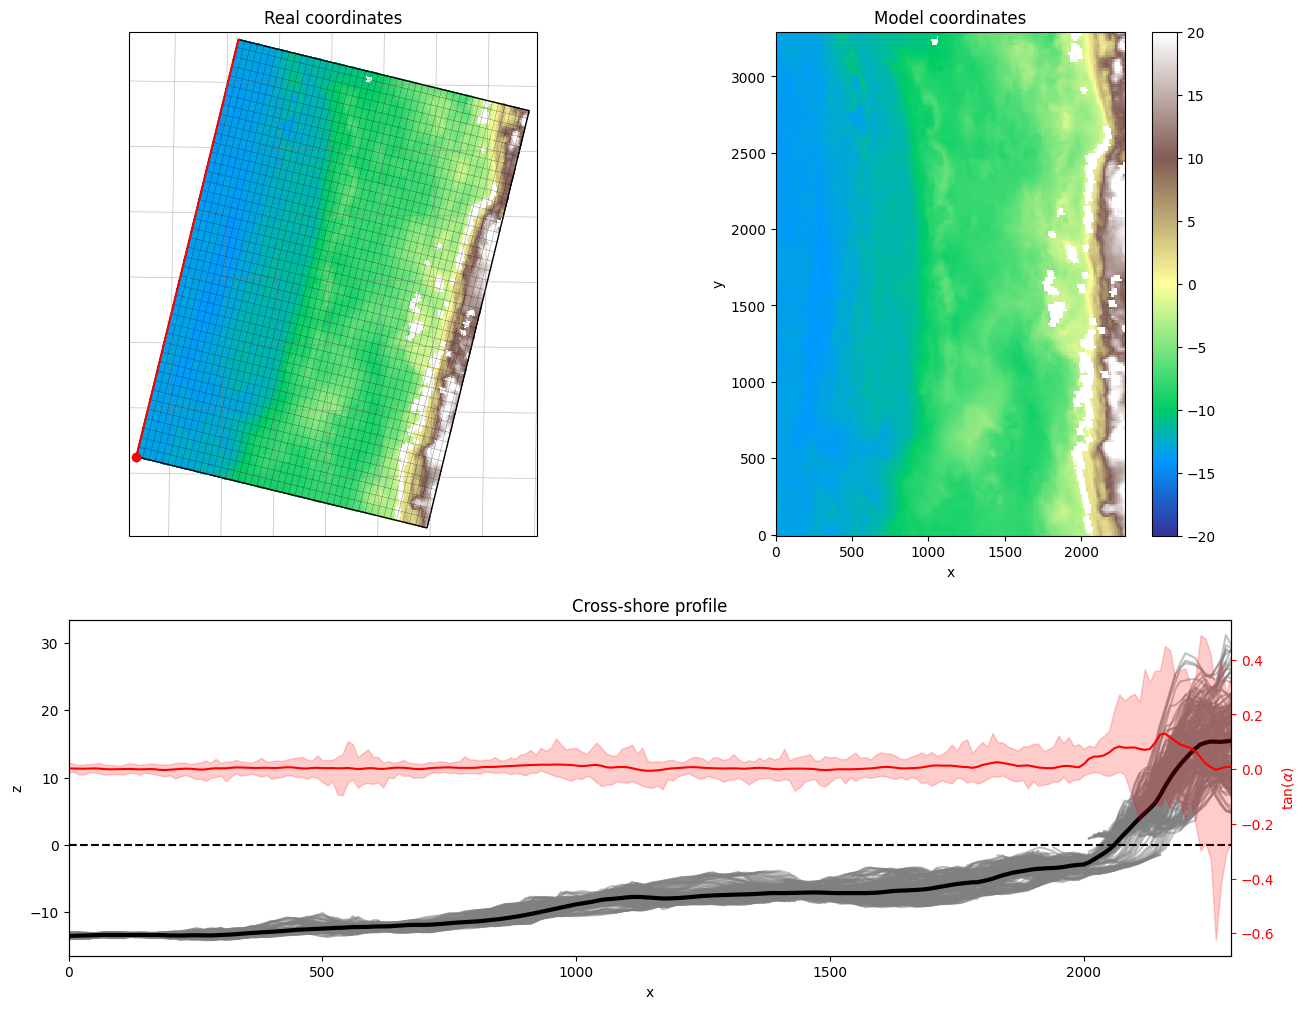

In [136]:
x1, y1, data1 = plot_model_bathy(xfile1, yfile1, datafile1, grid1)

### Example 2: Extend offshore boundary

INFO:rompy_xbeach.data:Reprojecting ../../../rompy-xbeach/tests/data/bathy.tif to EPSG:28350


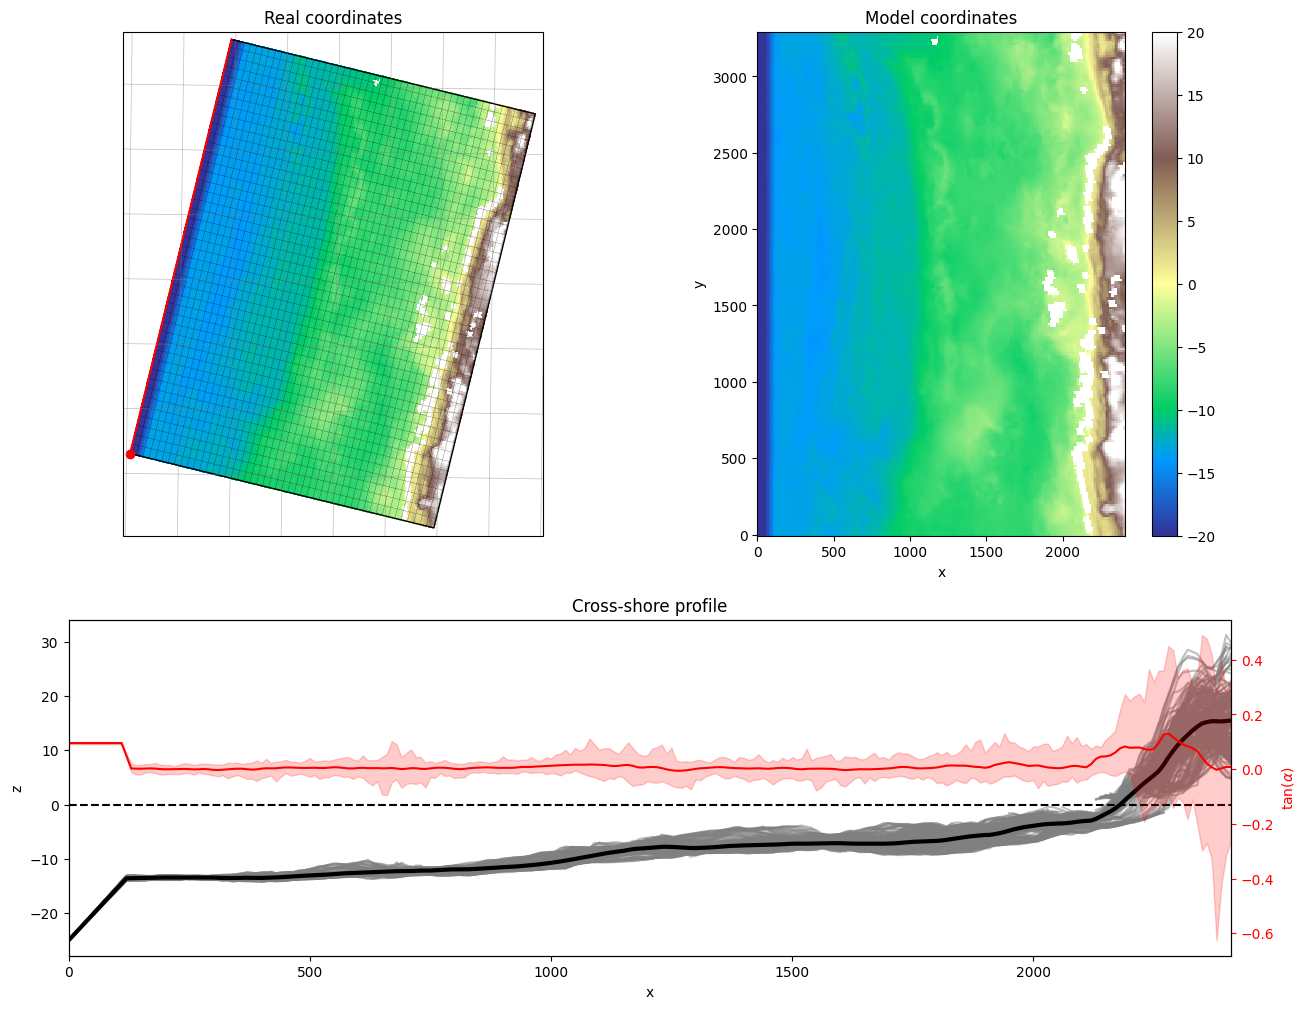

In [141]:
# The offshore extension is prescribed using one of the SeawardExtionsion subclasses
extension = SeawardExtensionLinear(
    depth=25,
    slope=0.1,
)

# Instantiate the data object with the new extension
data = XBeachBathy(
    source=source,
    posdwn=False,
    interpolator=interpolator,
    extension=extension,
)

# Generate the grid data
xfile2, yfile2, datafile2, grid2 = data.get(destdir=workspace, grid=grid)

# Plot the new bathy
x2, y2, data2 = plot_model_bathy(xfile2, yfile2, datafile2, grid2)

In [144]:
# Compare the shapes of the original and extended grid

print(data1.shape)
print(data2.shape)

(220, 230)
(220, 242)


#### The lesser the slope the longer the extension

INFO:rompy_xbeach.data:Reprojecting ../../../rompy-xbeach/tests/data/bathy.tif to EPSG:28350


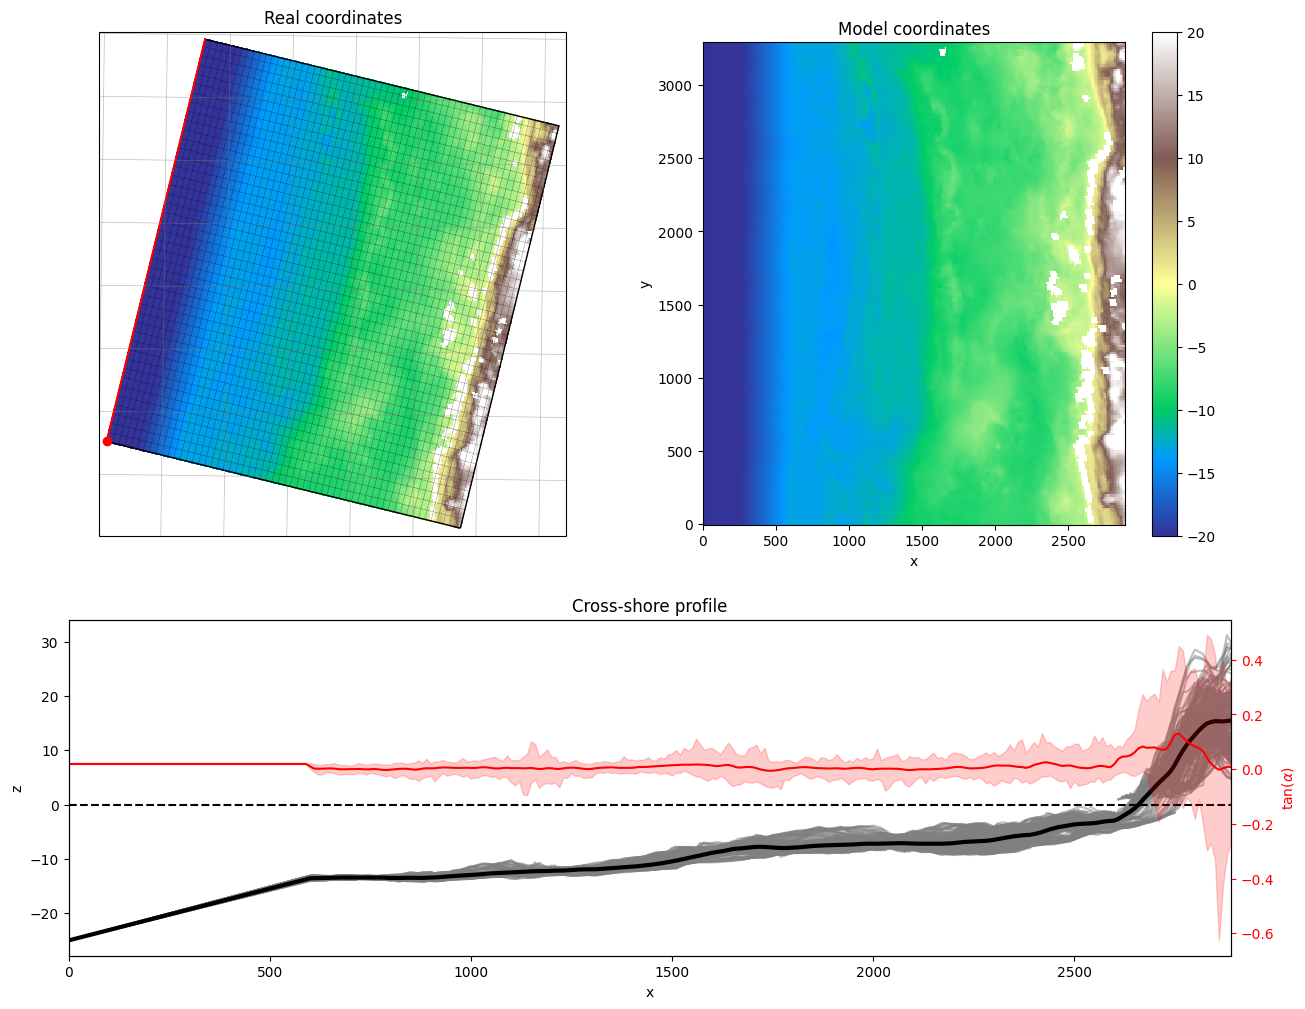

In [145]:
extension = SeawardExtensionLinear(
    depth=25,
    slope=0.02,
)

data = XBeachBathy(
    source=source,
    posdwn=False,
    interpolator=interpolator,
    extension=extension,
)

xfile3, yfile3, datafile3, grid3 = data.get(destdir=workspace, grid=grid)

x3, y3, data3 = plot_model_bathy(xfile3, yfile3, datafile3, grid3)